# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
 
### Purpose

Using PySyft, we have evaluated the model in a fix precision setting. We'll now try to assess how fix precision can influence the collateral learning.

# Collateral Learning


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import learn
from learn import main, train, test, show_results, show_confusion_matrix

## Loading the quadratic baseline
Let's train the baseline model and this how we can use its output to train a "adversarial/collateral" network!

In [3]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

Let's load the quadratic model that we saved in Part 3! _Be sure that the path and file name match._

In [4]:
PREC_FRAC = 3
quad_model = QuadNet(26)
path = '../data/models/quad_char.pt'
quad_model.load_state_dict(torch.load(path))
quad_model.eval()

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

Let's now convert the model in fixed precision!

In [5]:
import syft as sy
hook = sy.TorchHook(torch)
quad_model.fix_precision(precision_fractional=PREC_FRAC)

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

## Setting up the adversarial task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `adversarial_model` which will try to predict on another task, namely the family recognition

There are little change compared to the usual test, train and main functions.

In [6]:
def adversarial_train(args, adversarial_model, model, train_loader, adv_optimizer, epoch, prec_frac):
    adversarial_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data.fix_precision_(precision_fractional=prec_frac)  # <-- This is new
        data = model.transform(data)
        data = data.float_precision() # <-- This is new
        adv_optimizer.zero_grad()
        output = adversarial_model(data)
        loss = F.nll_loss(output, target)

        loss.backward()
        adv_optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def adversarial_test(args, adversarial_model, model, test_loader, prec_frac):
    adversarial_model.eval()
    test_loss = 0
    correct = 0
    pred_labels = None
    with torch.no_grad():
        for data, target in test_loader:
            data.fix_precision_(precision_fractional=prec_frac)  # <-- This is new
            data = model.transform(data) # <-- This is new
            data = data.float_precision() # <-- This is new
            output = adversarial_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc, None


This is the Adversarial model that we will use. We use the same CNN structure as seen previously.

In [7]:
class AdversarialCNN(nn.Module):
    def __init__(self, output_size):
        super(AdversarialCNN, self).__init__()
        self.lin1 = nn.Linear(26, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
import torch.optim as optim
import torch.utils.data as utils

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.seed = 1
        self.test_batch_size = 1000
        self.batch_size = 64
        self.no_cuda = False
        self.save_model = False
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    

The base quadratic model is already trained to detect char, which it does not to badly.

We new try to detect using its output, the family of the original input data.

In [9]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


In [10]:
def adversarial_phase(model, prec_frac):
    args = Parser()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    # setting = the family recognition task
    train_dataset = build_tensor_dataset(train_data, train_target_family)
    test_dataset = build_tensor_dataset(test_data, test_target_family)
    adversarial_output_size = 5
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    adversarial_model = AdversarialCNN(output_size=adversarial_output_size)
    adversarial_optimizer = optim.SGD(adversarial_model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        adversarial_train(args, adversarial_model, model, train_loader, adversarial_optimizer, epoch, prec_frac)
        acc, pred_labels = adversarial_test(args, adversarial_model, model, test_loader, prec_frac)
        test_perfs.append(acc)
        
    return test_perfs, pred_labels
        


In [11]:
test_perfs, pred_labels = adversarial_phase(quad_model, PREC_FRAC)
test_perfs

/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:194: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.628609
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.886271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.894976
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.725276

Test set: Average loss: 0.0007, Accuracy: 7352/10000 (73.52%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.577703
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.492930
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.614051
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.616409

Test set: Average loss: 0.0006, Accuracy: 7498/10000 (74.98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.543791
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.830955
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.566758
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.781394

Test set: Average loss: 0.0006, Accuracy: 7742/10000 (77.42%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.501914
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.566763
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.368901
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.412592

Test set: Average loss: 0.0

### Discussion

We observe that actually the collateral learning phase is also doing very well. This shows that it doesn't rely on very small signals, and that this is a threat that we can observe in the real FE setting.

Just for curiosity, we compare the learning curve with the collateral learning phase using floats. _You should report the result updated from Part 4_.

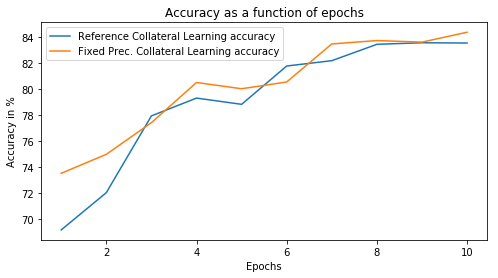

In [13]:
import matplotlib.pyplot as plt

cl_perf =    [69.16, 72.03, 77.94, 79.31, 78.83, 81.78, 82.19, 83.45, 83.57, 83.55]
fp_cl_perf = [73.52, 74.98, 77.42, 80.51, 80.03, 80.55, 83.48, 83.74, 83.62, 84.38]

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cl_perf) + 1), cl_perf, label='Reference Collateral Learning accuracy')
plt.plot(range(1, len(fp_cl_perf) + 1), fp_cl_perf, label='Fixed Prec. Collateral Learning accuracy')
plt.ylabel('Accuracy in %')
plt.xlabel('Epochs')
plt.title('Accuracy as a function of epochs')
plt.legend()
plt.show()

### Conclusion

Now that we have established the threats associated with intermediate public neural network outputs, we'll try to find method to mitigate collateral information leakage without downgrading to much the accuracy on the main task.